In [1486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for pipelines and grid search
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality Reduction algoriths
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE
from sklearn.manifold import LocallyLinearEmbedding

# Classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics for evaluating classification models
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

import shap

import datetime

import random

import warnings
warnings.filterwarnings("ignore")

### 1. Exploratory Data Analysis

In [1487]:
# Import the raw data from clinical and cnrq/miRNA samples data files

df_clinical = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\ICORG database for analysis 2021 - clinical - CSV.csv")

df_cnrq = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\ICORG database for analysis 2021 - cnrq - CSV.csv")

df_cnrq.drop('Unnamed: 17', axis=1, inplace=True)

In [1488]:
# Take a look at the the two data frames

df_clinical.head()

Patient No.   Age ER Status PR Status HER2 Status Tumour Subtype  \
0          1.0  67.0  Positive  Negative    Negative      Luminal A   
1          2.0  53.0  Positive  Positive    Negative      Luminal A   
2          3.0  65.0  Positive  Positive    Negative      Luminal A   
3          4.0   NaN  Positive  Negative    Positive      Luminal B   
4          5.0   NaN  Positive  Positive    Positive      Luminal B   

  Node Result  Mammogram Size  Tumour Grade Surgical Procedure  \
0    Negative             NaN           2.0                WLE   
1         NaN             4.0           2.0                WLE   
2    Positive             7.0           2.0                WLE   
3    Positive             7.0           2.0         Mastectomy   
4    Negative             NaN           2.0         Mastectomy   

   Invasive Tumour size on histology (cm) Tumour bed response to NACT  \
0                                     3.0                     Partial   
1                                     6.3                     Partial   
2                                     4.0                     Partial   
3                                     3.8                        Good   
4                                     1.4                        Good   

   Number of Nodes Involved Final combined pCR status   NPI  Mammographic NPI  
0                       5.0                        No  5.60               NaN  
1                       3.0                        No  6.26               4.8  
2                      13.0                        No  5.60               6.4  
3                       4.0                        No  5.76               6.4  
4                       0.0                        No  3.28               NaN

In [1489]:
df_cnrq.head()

Samples Let-7a CNRQ Let-7a SE(CNRQ) miR-10b CNRQ miR-10b SE(CNRQ)  \
0     1-1    0.619542        0.043492    -0.258232         0.022169   
1     1-2    0.268956        0.031020     0.466741         0.037892   
2     1-3   -0.330399        0.038581    -0.271332         0.038458   
3     1-4    1.202915        0.019768     1.314104         0.016260   
4     1-5    0.668195        0.029424     0.473851         0.031627   

  miR-145 CNRQ miR-145 SE(CNRQ) miR-155 CNRQ miR-155 SE(CNRQ) miR-16 CNRQ  \
0     0.248945         0.032727    -1.948633         0.038655    0.245929   
1     0.688605         0.029129          NaN              NaN    0.249567   
2     0.354952         0.031385     0.057162         0.040371   -0.265812   
3     1.859136         0.038551     1.561874         0.019562    1.117200   
4     0.841119         0.025823    -3.370786         0.045068    0.241619   

  miR-16 SE(CNRQ) miR-195 CNRQ miR-195 SE(CNRQ) miR-21 CNRQ miR-21 SE(CNRQ)  \
0        0.010475     0.756180         0.012659    0.588606        0.013795   
1        0.014383     0.528927         0.020011    0.631142        0.028848   
2        0.021709    -0.283067         0.029393   -0.297470        0.036457   
3        0.010158    -0.496248         0.030897    1.799202        0.025332   
4        0.035241     0.713116         0.020807    0.788514        0.039980   

  miR-425 CNRQ miR-425 SE(CNRQ)  
0    -0.245929         0.014497  
1    -0.249567         0.020417  
2     0.265812         0.027783  
3    -1.117200         0.019028  
4    -0.241619         0.024060

In [1490]:
# Create two new features by splitting the "Sample" feature into "Patient No." and "Sample No."
df_cnrq.insert(0,'Patient No.',df_cnrq.Samples.str.split('-').str[0])
df_cnrq.insert(1,'Sample No.',df_cnrq.Samples.str.split('-').str[1])
df_cnrq.drop('Samples', axis=1, inplace=True)

idxs = list(df_cnrq.columns)[0:2]
cols = list(df_cnrq.columns)[2:]

df_cnrq[idxs] = df_cnrq[idxs].apply(pd.to_numeric, errors='coerce', axis=1)
df_cnrq[cols] = df_cnrq[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df_clinical['Patient No.'] = df_clinical['Patient No.'].apply(pd.to_numeric, errors='coerce')

In [1491]:
# Each patient has up to 5 sample rows for each miRNA measurement so we need to denormalise before joining

f_cnrq_denorm = pd.DataFrame()

# Denormalisation routine

for x in range(1, 6):
    temp_df = df_cnrq[(df_cnrq['Sample No.'] == x)].copy()
    
    cols = temp_df.columns[2:]
    
    for col in cols:
        new_col = "Sample_" + str(x) + "_" + col
        temp_df.rename(columns = {col:new_col}, inplace = True)

    temp_df.drop('Sample No.', axis=1, inplace=True)
    temp_df.set_index('Patient No.')
    
    if x > 1:
        df_cnrq_denorm = pd.merge(df_cnrq_denorm, temp_df, how='left', on='Patient No.')

    else:
        df_cnrq_denorm = temp_df.copy()   

# Join datasets
df = pd.merge(df_clinical, df_cnrq_denorm, on='Patient No.', how='left')

In [1492]:
# Drop rows with all columns data missing values

df = df.dropna(how='all')

In [1493]:
# Based on discussion with James, columns with'_miR_10' can be deleted as well as all of Sample 5

del_col_names = ['Sample_1_miR-10b CNRQ', 'Sample_1_miR-10b SE(CNRQ)',
                 'Sample_2_miR-10b CNRQ', 'Sample_2_miR-10b SE(CNRQ)',
                 'Sample_3_miR-10b CNRQ', 'Sample_3_miR-10b SE(CNRQ)',
                 'Sample_4_miR-10b CNRQ', 'Sample_4_miR-10b SE(CNRQ)',
                 'Sample_5_miR-10b CNRQ', 'Sample_5_miR-10b SE(CNRQ)'
                ]
df = df.drop(del_col_names, axis=1)

# Drop columns from Sample 5

df = df.drop(df.filter(regex='Sample_[2-5]').columns, axis=1)

df = df.drop(df.filter(regex='Unnamed').columns, axis=1)

In [1494]:
df.columns

Index(['Patient No.', 'Age', 'ER Status', 'PR Status', 'HER2 Status',
       'Tumour Subtype', 'Node Result', 'Mammogram Size', 'Tumour Grade',
       'Surgical Procedure', 'Invasive Tumour size on histology (cm)',
       'Tumour bed response to NACT', 'Number of Nodes Involved',
       'Final combined pCR status', 'NPI', 'Mammographic NPI',
       'Sample_1_Let-7a CNRQ', 'Sample_1_Let-7a SE(CNRQ)',
       'Sample_1_miR-145 CNRQ', 'Sample_1_miR-145 SE(CNRQ)',
       'Sample_1_miR-155 CNRQ', 'Sample_1_miR-155 SE(CNRQ)',
       'Sample_1_miR-16 CNRQ', 'Sample_1_miR-16 SE(CNRQ)',
       'Sample_1_miR-195 CNRQ', 'Sample_1_miR-195 SE(CNRQ)',
       'Sample_1_miR-21 CNRQ', 'Sample_1_miR-21 SE(CNRQ)',
       'Sample_1_miR-425 CNRQ', 'Sample_1_miR-425 SE(CNRQ)'],
      dtype='object')

In [1495]:
# Reset all 'missing' values with standard NaN

df = df.replace('Missing', np.NaN)

In [1496]:
# Drop Mammographic NPI, for now, as it has a large amount of missing data
# Drop NPI as this is a calculated value from Invasive Tumour Size, Number of Nodes and Tumour Grade
# Patient No. is not needed for this part of the analysis

drop_cols = ['ER Status', 'Mammographic NPI', 'Patient No.', 'NPI']

df = df.drop(drop_cols, axis=1)

In [1497]:
df.shape

(124, 26)

In [1498]:
# Summary statistics on numeric data

df.describe()

Age  Mammogram Size  Tumour Grade  \
count  102.000000       89.000000    122.000000   
mean    55.088235        4.173034      2.459016   
std     10.599928        2.065670      0.516625   
min     25.000000        0.800000      1.000000   
25%     48.000000        2.800000      2.000000   
50%     55.000000        3.700000      2.000000   
75%     63.000000        5.000000      3.000000   
max     76.000000       10.000000      3.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                              116.000000                120.000000   
mean                                 2.423190                  2.916667   
std                                  3.442705                  5.389974   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  1.350000                  0.000000   
75%                                  3.850000                  3.250000   
max                                 24.000000                 26.000000   

       Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count            112.000000                112.000000             111.000000   
mean              -0.079412                  0.026967               0.008271   
std                0.732854                  0.012864               0.578259   
min               -3.099901                  0.008775              -2.286769   
25%               -0.465806                  0.017465              -0.336913   
50%                0.007653                  0.024258               0.142475   
75%                0.349460                  0.035144               0.386108   
max                1.606284                  0.101109               1.287875   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                 111.000000             113.000000   
mean                    0.028359              -0.154860   
std                     0.014445               0.835144   
min                     0.003589              -4.049647   
25%                     0.017690              -0.339528   
50%                     0.026165               0.000212   
75%                     0.035616               0.228773   
max                     0.103618               2.219914   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                 113.000000            116.000000   
mean                    0.027256              0.006177   
std                     0.013255              0.292226   
min                     0.004295             -0.722485   
25%                     0.018420             -0.164788   
50%                     0.026023             -0.008289   
75%                     0.034086              0.191508   
max                     0.102839              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                116.000000             113.000000   
mean                   0.021113              -0.045760   
std                    0.013447               0.583540   
min                    0.001627              -2.272715   
25%                    0.012525              -0.290821   
50%                    0.018521               0.079972   
75%                    0.025076               0.357126   
max                    0.103076               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                 113.000000            113.000000   
mean                    0.024106             -0.175079   
std                     0.012219              0.795284   
min                     0.008899             -4.472507   
25%                     0.016539             -0.347641   
50%                     0.021701             -0.100311   
75%                     0.029127              0.269272   
max                     0.102075              1.049880   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  

In [1499]:
# Calculate the percentage of missing data for each feature

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.isna().sum()/df.shape[0]*100

Age                                       17.741935
PR Status                                  0.000000
HER2 Status                                0.000000
Tumour Subtype                             0.000000
Node Result                               27.419355
Mammogram Size                            28.225806
Tumour Grade                               1.612903
Surgical Procedure                         1.612903
Invasive Tumour size on histology (cm)     6.451613
Tumour bed response to NACT                3.225806
Number of Nodes Involved                   3.225806
Final combined pCR status                  3.225806
Sample_1_Let-7a CNRQ                       9.677419
Sample_1_Let-7a SE(CNRQ)                   9.677419
Sample_1_miR-145 CNRQ                     10.483871
Sample_1_miR-145 SE(CNRQ)                 10.483871
Sample_1_miR-155 CNRQ                      8.870968
Sample_1_miR-155 SE(CNRQ)                  8.870968
Sample_1_miR-16 CNRQ                       6.451613
Sample_1_miR

In [1500]:
# Plot the distribution of categorical features to determine class imbalance

all_cols = df.columns
cols = df.select_dtypes(include='number').columns

cat_cols = list(set(all_cols) - set(cols))

for cat in cat_cols:
    cnt = df[cat].count()
    num_elem = (df.groupby([cat])[cat].count())/cnt*100
    print (num_elem, '\n')

Node Result
Negative    14.444444
Positive    85.555556
Name: Node Result, dtype: float64 

PR Status
Negative    46.774194
Positive    53.225806
Name: PR Status, dtype: float64 

Tumour bed response to NACT
Complete    32.500000
Good        14.166667
Partial     45.000000
Poor         8.333333
Name: Tumour bed response to NACT, dtype: float64 

HER2 Status
Negative    69.354839
Positive    30.645161
Name: HER2 Status, dtype: float64 

Tumour Subtype
Her2               12.903226
Luminal A          49.193548
Luminal B          17.741935
Triple Negative    20.161290
Name: Tumour Subtype, dtype: float64 

Surgical Procedure
Mastectomy    44.262295
WLE           55.737705
Name: Surgical Procedure, dtype: float64 

Final combined pCR status
No     73.333333
Yes    26.666667
Name: Final combined pCR status, dtype: float64 



In [1501]:
# Plot histograms of number values

#fig = plt.figure(figsize=(16,300))
#n= 1
#num = len(cols)

#for col in cols:
#    ax1 = fig.add_subplot(num, 2, n)
#    ax1.set_title(col)
#    df.boxplot(column=col)

#    ax2 = fig.add_subplot(num, 2, n+1)
#    ax2.set_title(col)
#    df[col].hist(bins=20)
    
#    n+=2

In [1502]:
# Export the df dataset (unprocessed)

df.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")

#### Pre-processing Checkpoint

In [1503]:
df =  pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [1504]:
# Map 'Tumour Grade' to number values for classification model

tumour_grade = {1 : 0, 2: 1, 3: 2}

df['Tumour Grade'] = df['Tumour Grade'].map(tumour_grade)

In [1505]:
df.shape

(124, 26)

In [1506]:
# Check for balance in Tumour Grade

df.groupby(['Tumour Grade'])['Tumour Grade'].count()

Tumour Grade
0.0     1
1.0    64
2.0    57
Name: Tumour Grade, dtype: int64

**Note**: Tumour Grade Class 0 has only one row which cannot be used in modelling. Remove from dataset, but we will not be able to predict these classes of Tumour Grades

In [1507]:
# Drop rows where target feature is NA or equal to 1
idx = df[ (df['Tumour Grade'].isna()) | (df['Tumour Grade'] == 0)].index
df.drop(idx, inplace=True)

In [1508]:
# Re-map 'Tumour Grade' to number values for classification model

tumour_grade = {1 : 0, 2: 1}

df['Tumour Grade'] = df['Tumour Grade'].map(tumour_grade)

In [1509]:
# Re-check for balance in Tumour Grade

df.groupby(['Tumour Grade'])['Tumour Grade'].count()

Tumour Grade
0    64
1    57
Name: Tumour Grade, dtype: int64

In [1510]:
df.shape

(121, 26)

In [1511]:
# Separate the dataset into Training and Test Datasets before doing any analysis or feature engineering
# NOTE: Separating the data depends on whether we will be doing regression or classification.
# Classification needs to be stratified on the target so we get even distributions of classes in train and test.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Tumour Grade'])
print("Dataset shape: Training", df_train.shape, "Test", df_test.shape)

Dataset shape: Training (96, 26) Test (25, 26)


In [1512]:
# Calculate skewness of distribution

from scipy.stats import skew

skew_df = pd.DataFrame(columns=['Feature', 'Skewness'])

cols = df_train.select_dtypes(include='number').columns

for col in cols:
    skew_val = np.round(skew(df_train[col], nan_policy='omit'), 4)
    new_row = {'Feature': col, 'Skewness': skew_val}
    skew_df = skew_df.append(new_row, ignore_index=True)

skew_df

Feature  Skewness
0                                      Age   -0.1030
1                           Mammogram Size    0.5838
2                             Tumour Grade    0.1252
3   Invasive Tumour size on histology (cm)    1.5575
4                 Number of Nodes Involved    2.5991
5                     Sample_1_Let-7a CNRQ   -1.0553
6                 Sample_1_Let-7a SE(CNRQ)    2.0975
7                    Sample_1_miR-145 CNRQ   -0.9295
8                Sample_1_miR-145 SE(CNRQ)    1.5082
9                    Sample_1_miR-155 CNRQ   -2.1168
10               Sample_1_miR-155 SE(CNRQ)    2.1093
11                    Sample_1_miR-16 CNRQ   -0.0321
12                Sample_1_miR-16 SE(CNRQ)    2.6824
13                   Sample_1_miR-195 CNRQ   -1.3130
14               Sample_1_miR-195 SE(CNRQ)    2.5636
15                    Sample_1_miR-21 CNRQ   -2.1982
16                Sample_1_miR-21 SE(CNRQ)    1.9575
17                   Sample_1_miR-425 CNRQ    0.0321
18               Sample_1_miR-425 SE(CNRQ)    6.8723

#### Determining Mean or Median imputer for Skewed Data
From: https://www.pluralsight.com/guides/interpreting-data-using-descriptive-statistics-python

- Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

- Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

- Approximately symmetric distribution: If the skewness value is between −½ and +½.

Therefore, for _Skewness_ values between -0.5 and + 0.5 we use *mean* otherwise use *median*.

This is also very useful in determining whether to use MinMaxScaler or StandardScaler.

MinmaxScaler is negatively impacted by large skewness, i.e. outliers, while StandardScaler is not.

We can use StandardScaler followed by MinMax.

### 2. Data Pre-processing

In [1513]:
# Impute for missing values

cols_mean = []
cols_median = []

for col in cols:
    skewness = skew(df_train[col], nan_policy='omit')
    if skewness >= -0.5 and skewness <= 0.5:
        cols_mean.append(col)
    else: cols_median.append(col)
        
# Calculate mean and median for columns in each list and store for later use with test dataset
# Values stored in for each feature will replace missing data, i.e. NaNs

feature_impute_vals = pd.DataFrame(columns=['Feature', 'Value'])

for col in cols_mean:
    mean = np.mean(df_train[col])
    new_row={'Feature':col, 'Value':mean}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)
    
for col in cols_median:
    median = np.nanmedian(df_train[col])
    new_row={'Feature':col, 'Value':median}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)

# Round features where values must be integers
int_features = ('Age', 'Number of Nodes Involved')
for index in feature_impute_vals.index:
    if feature_impute_vals.loc[index, 'Feature'] in int_features:
        feature_impute_vals.loc[index, 'Value'] = round(feature_impute_vals.loc[index, 'Value'])

# Impute values in each column for missing values
 
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_train[col_name].fillna(col_value, inplace=True)
    


In [1514]:
# One-hot encode the categrical data

ohe_cols = ['PR Status', 'HER2 Status', 'Node Result','Surgical Procedure', 
            'Final combined pCR status', 'Tumour bed response to NACT', 'Tumour Subtype']

df_train = pd.get_dummies(df_train, columns=ohe_cols, dummy_na=True)

In [1515]:
# Check for missing values after processing

df_train.isna().sum()/df.shape[0]*100

Age                                       0.0
Mammogram Size                            0.0
Tumour Grade                              0.0
Invasive Tumour size on histology (cm)    0.0
Number of Nodes Involved                  0.0
Sample_1_Let-7a CNRQ                      0.0
Sample_1_Let-7a SE(CNRQ)                  0.0
Sample_1_miR-145 CNRQ                     0.0
Sample_1_miR-145 SE(CNRQ)                 0.0
Sample_1_miR-155 CNRQ                     0.0
Sample_1_miR-155 SE(CNRQ)                 0.0
Sample_1_miR-16 CNRQ                      0.0
Sample_1_miR-16 SE(CNRQ)                  0.0
Sample_1_miR-195 CNRQ                     0.0
Sample_1_miR-195 SE(CNRQ)                 0.0
Sample_1_miR-21 CNRQ                      0.0
Sample_1_miR-21 SE(CNRQ)                  0.0
Sample_1_miR-425 CNRQ                     0.0
Sample_1_miR-425 SE(CNRQ)                 0.0
PR Status_Negative                        0.0
PR Status_Positive                        0.0
PR Status_nan                     

#### Pre-processing checkpoint

In [1516]:
# Export the df dataset (processed)

df_train.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_pCR_Status.csv")

In [1517]:
df_train = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_pCR_Status.csv")
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [1518]:
# Apply MinMaxScaler to X_Train
all_cols = list(df_train.columns)
all_cols.remove('Tumour Grade')

#scaler=StandardScaler()
#df_train[all_cols]=scaler.fit_transform(df_train[all_cols])

#minmax=MinMaxScaler(feature_range=(0, 1))
#df_train[all_cols]=minmax.fit_transform(df_train[all_cols])


In [1519]:
df_train.describe()

Age  Mammogram Size  Tumour Grade  \
count  96.000000       96.000000     96.000000   
mean   55.270833        4.129167      0.468750   
std     9.938208        1.679280      0.501642   
min    25.000000        0.800000      0.000000   
25%    48.750000        3.200000      0.000000   
50%    55.000000        4.000000      0.000000   
75%    62.000000        4.100000      1.000000   
max    76.000000       10.000000      1.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                               96.000000                 96.000000   
mean                                 2.421875                  2.541667   
std                                  2.902873                  4.877266   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  1.450000                  0.000000   
75%                                  4.000000                  2.000000   
max                                 14.000000                 26.000000   

       Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count             96.000000                 96.000000              96.000000   
mean              -0.052603                  0.027239               0.035771   
std                0.700292                  0.012713               0.579124   
min               -3.099901                  0.008775              -2.286769   
25%               -0.393182                  0.017907              -0.321867   
50%                0.028164                  0.025199               0.152419   
75%                0.337376                  0.034600               0.381122   
max                1.606284                  0.101109               1.287875   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                  96.000000              96.000000   
mean                    0.029828              -0.101114   
std                     0.014262               0.836918   
min                     0.004868              -4.049647   
25%                     0.020256              -0.319276   
50%                     0.028750               0.037639   
75%                     0.036687               0.294834   
max                     0.103618               2.219914   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                  96.000000             96.000000   
mean                    0.027265              0.029058   
std                     0.012874              0.275479   
min                     0.004295             -0.722485   
25%                     0.018878             -0.116307   
50%                     0.026329              0.027701   
75%                     0.032488              0.189276   
max                     0.102839              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 96.000000              96.000000   
mean                   0.021237              -0.008630   
std                    0.013435               0.555094   
min                    0.004167              -2.272715   
25%                    0.012878              -0.271648   
50%                    0.018520               0.128737   
75%                    0.024885               0.320234   
max                    0.103076               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  96.000000             96.000000   
mean                    0.024738             -0.137172   
std                     0.012585              0.760718   
min                     0.008899             -4.472507   
25%                     0.017010             -0.302391   
50%                     0.021271             -0.067678   
75%                     0.029560              0.259349   
max                     0.102075              1.049880   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
count 

In [1520]:
# Split df_train into dependent and target features

y_train = df_train['Tumour Grade']
X_train = df_train.drop('Tumour Grade', axis=1).values

In [1521]:
# Process test dataset for evaluation

# Impute values in each column for missing values
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_test[col_name].fillna(col_value, inplace=True)

# One-hot encode the categrical data
ohe_cols = ['PR Status', 'HER2 Status', 'Node Result','Surgical Procedure', 
            'Final combined pCR status', 'Tumour bed response to NACT', 'Tumour Subtype']

df_test = pd.get_dummies(df_test, columns=ohe_cols, dummy_na=True)

# Apply scalers to df_test

all_cols = list(df_test.columns)
all_cols.remove('Tumour Grade')

#df_test[all_cols]=scaler.transform(df_test[all_cols])

#df_test[all_cols]=minmax.transform(df_test[all_cols])


y_test = df_test['Tumour Grade']
X_test = df_test.drop('Tumour Grade', axis=1).values

In [1522]:
X_train.shape, X_test.shape

((96, 43), (25, 43))

### 3. XGBoost Classifier Pipeline

In [1523]:
# Instantiate the piepline for evaluating the best XGBoost Regressor model hyperparameters
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', XGBClassifier(tree_method='auto', booster='gbtree', verbosity=0, silent=True))])

In [1524]:
# Define hyperparameter ranges to evaluate during GridSearch

N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_ESTIMATORS_OPTIONS = [10, 50, 100, 500]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
GAMMA_OPTIONS = [100, 50, 10, 1, 0, 0.1, 0.01, 0.001]

param_grid = [
    {
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS
    }
]

In [1525]:
# Instantiate GridSearch with pipeline and hyperparameter grid
print("Start processing .....")

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_

print("End of processing .....")

Start processing .....
Best CV score = 0.721:
Best parameters:  {'classifier__gamma': 1, 'classifier__max_depth': 2, 'classifier__n_estimators': 10}
End of processing .....


Classification report for XGBoost Classifier 
               precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.69      0.75      0.72        12

    accuracy                           0.72        25
   macro avg       0.72      0.72      0.72        25
weighted avg       0.72      0.72      0.72        25

Accuracy score:  0.9166666666666666 (Train),  0.72 (Test)
Area Under the Curve (AUC): 0.9769063180827887 (Train) 0.8525641025641025 (Test)
Precision:  0.9166666666666666 (Train),  0.7223076923076923 (Test)
Recall:  0.9166666666666666 (Train),  0.72 (Test)
f1-score:  0.9166666666666666 (Train),  0.7199999999999999 (Test)


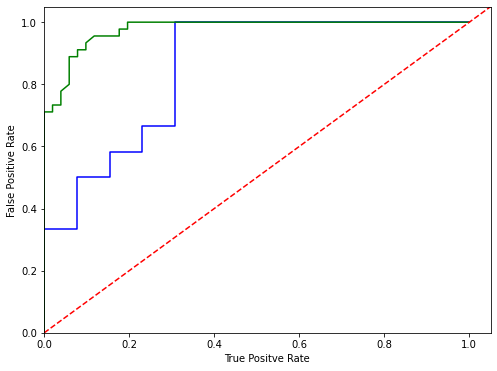

In [1526]:
# Calculate metrics for evaluation
XGB_best_model.fit(X_train, y_train)

XGB_train_pred = XGB_best_model.predict(X_train)
XGB_test_pred = XGB_best_model.predict(X_test)
XGB_train_pred_proba = XGB_best_model.predict_proba(X_train)
XGB_test_pred_proba = XGB_best_model.predict_proba(X_test)

print("Classification report for XGBoost Classifier \n", metrics.classification_report(y_test, XGB_test_pred))

# Calculate classification metrics
XGB_train_accuracy = metrics.accuracy_score(y_train, XGB_train_pred)
XGB_test_accuracy = metrics.accuracy_score(y_test, XGB_test_pred)
XGB_train_auc = metrics.roc_auc_score(y_train, XGB_train_pred_proba[:,1])
XGB_test_auc = metrics.roc_auc_score(y_test, XGB_test_pred_proba[:,1])
XGB_train_fp, XGB_train_tp, _ = metrics.roc_curve(y_train, XGB_train_pred_proba[:,1])
XGB_test_fp, XGB_test_tp, _ = metrics.roc_curve(y_test, XGB_test_pred_proba[:,1])
XGB_train_roc_auc = metrics.auc(XGB_train_fp, XGB_train_tp)
XGB_test_roc_auc = metrics.auc(XGB_test_fp, XGB_test_tp)
XGB_train_precision, XGB_train_recall, XGB_train_f1_score, _ = precision_recall_fscore_support(
    y_train, XGB_train_pred, average='weighted')
XGB_test_precision, XGB_test_recall, XGB_test_f1_score, _ = precision_recall_fscore_support(
    y_test, XGB_test_pred, average='weighted')

print("Accuracy score: ", XGB_train_accuracy, "(Train), ", XGB_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", XGB_train_auc, "(Train)", XGB_test_auc, "(Test)")
print("Precision: ", XGB_train_precision, "(Train), ", XGB_test_precision, "(Test)")
print("Recall: ", XGB_train_recall, "(Train), ", XGB_test_recall, "(Test)")
print("f1-score: ", XGB_train_f1_score, "(Train), ", XGB_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(XGB_test_fp, XGB_test_tp, 'b', label='AUC (test) = %0.2f'%XGB_test_roc_auc)
plt.plot(XGB_train_fp, XGB_train_tp, 'g', label='AUC (train) = %0.2f'%XGB_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

### 4. SHAP Feature Analysis

In [1527]:
# Initialising the SHAP explainer
model = XGBClassifier(gamma = 1, max_depth=2, tree_method='auto', booster='gbtree', verbosity=0, silent=True)
model.fit(X_train, y_train)
xgb_explain = shap.TreeExplainer (model)

In [1528]:
# Calculate the Shap Values for the model features

shap_values_tr = xgb_explain.shap_values(X_train)
shap_values_ts = xgb_explain.shap_values(X_test)

#print(shap_values_tr.shape, shap_values_ts.shape)

In [1529]:
features = list(df_train.columns)
features.remove('Tumour Grade')

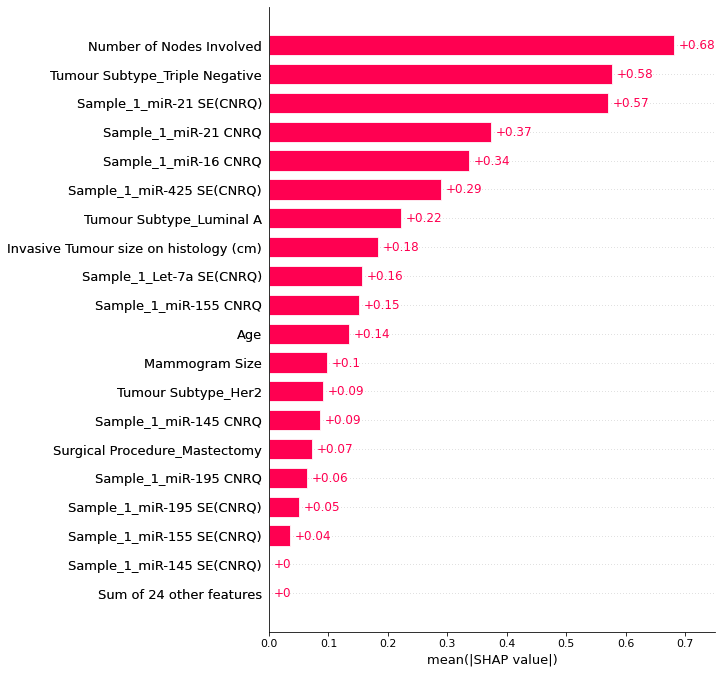

In [1530]:
# Generate SHAP Global Variable Importance Plot
X = df_test.drop('Tumour Grade', axis=1)
explain = shap.Explainer(model, X)
sh_values = explain(X)

shap.plots.bar(sh_values, max_display=20)

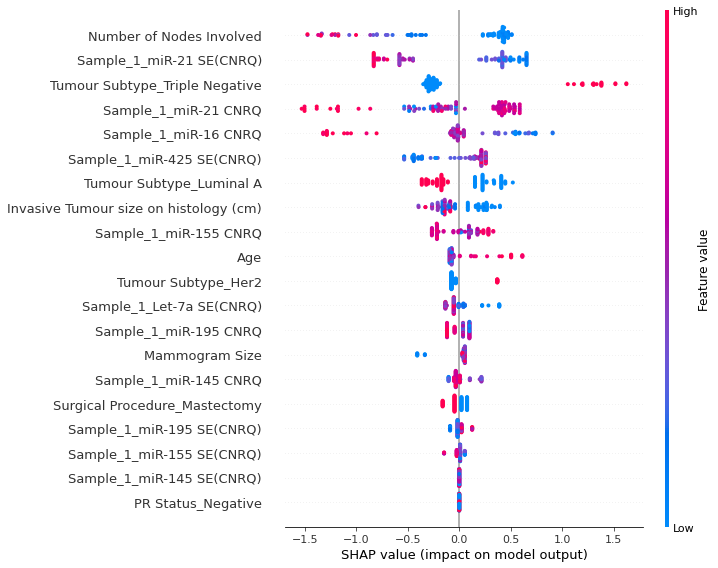

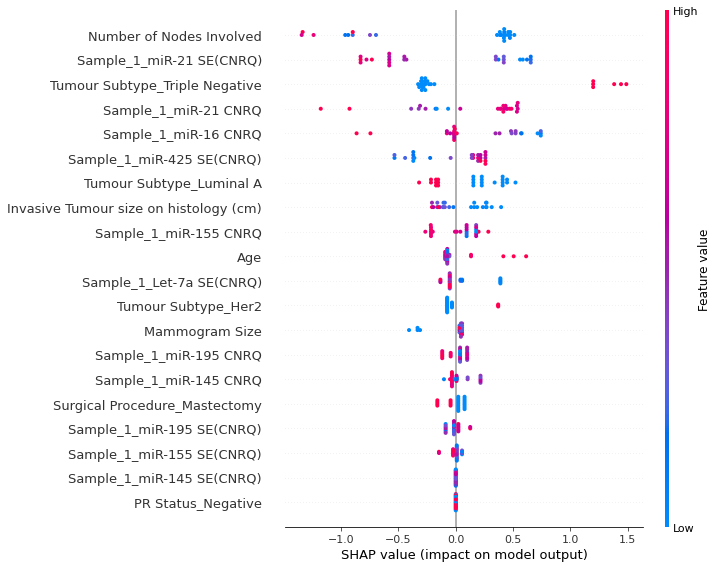

In [1531]:
# Generate SHAP Summary Plot

shap.summary_plot(shap_values_tr, X_train, plot_type="dot", feature_names=features)

shap.summary_plot(shap_values_ts, X_test, plot_type="dot", feature_names=features)

In [1532]:
# Select a random patient and further analyse their prediction of 'Final combined pCR status'
X_random = df_test.sample(1, random_state = 42)
X_sample = X_random.drop('Tumour Grade', axis=1).values

#generate a prediction for the row
rand_pred = model.predict(X_sample)
rand_proba = model.predict_proba(X_sample)

print(f'Predicted Probability (no, yes): {rand_proba}')
print(f'Predicted Tumour Grade (0 = no, 1 = yes): {rand_pred}','\n')

Predicted Probability (no, yes): [[0.9593993  0.04060074]]
Predicted Tumour Grade (0 = no, 1 = yes): [0] 



In [1533]:
# Gnerate TreeExplainer for probability
xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', feature_dependence='independent', data=X_test)

In [1534]:
# Generate the expected value
expected_value = xgb_explain_prob.expected_value

In [1535]:
expected_value

0.5530758109266896

In [1536]:
# Check that the modle behaves as expected - need a value 'True' here

# Gnerate SHAP values for test data
shap_xgb_values_test = xgb_explain_prob.shap_values(X_test)

# Generate predictions from the SHAP values
y_test_shap_pred = (shap_xgb_values_test.sum(1) + expected_value) > 0.5

#Generate predictions from the model
y_test_xgb_pred = model.predict(X_test)

# Check that both methods generate the sae results
print(np.array_equal(y_test_shap_pred, y_test_xgb_pred ))

True


In [1606]:
# Predefined samples
sample_patients_idx = [3,5,6,7,8]

In [1607]:
# Generate FALSE NEGATIVEs
FN = (~y_test_shap_pred[sample_patients_idx]) & (y_test.iloc[sample_patients_idx] == 1).to_numpy()

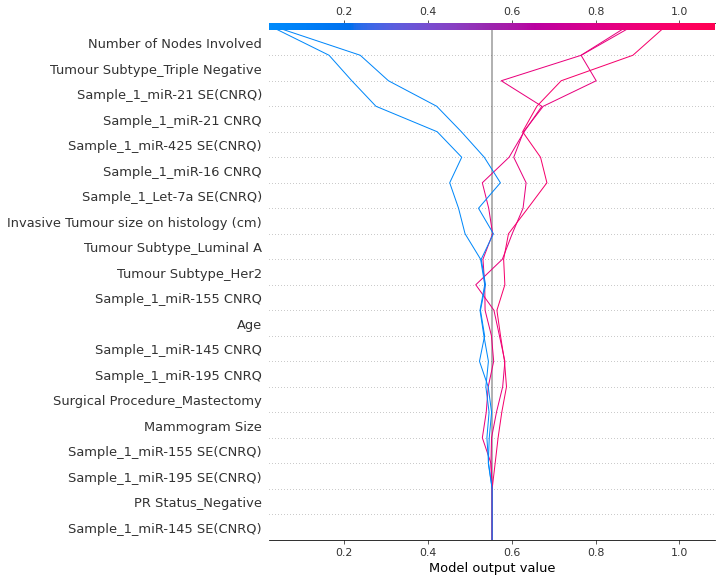

In [1608]:
shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

In [1624]:
# Predefined samples
sample_patients_idx = [3,5,7,12,13]

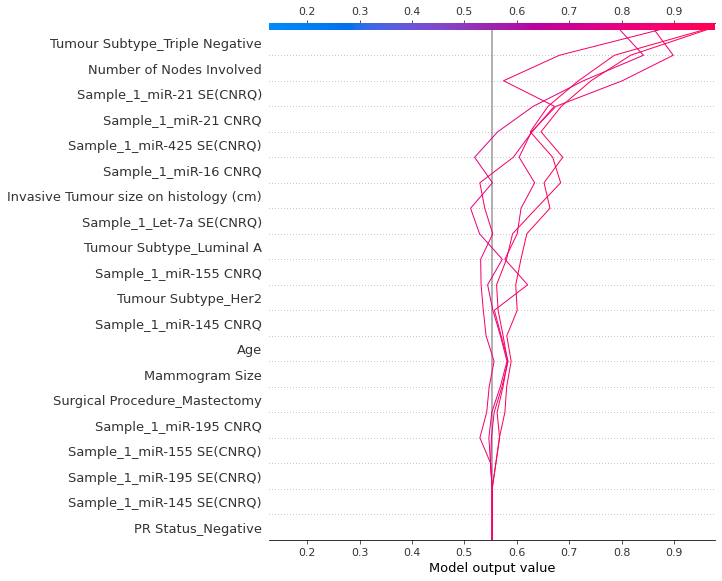

In [1625]:
shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

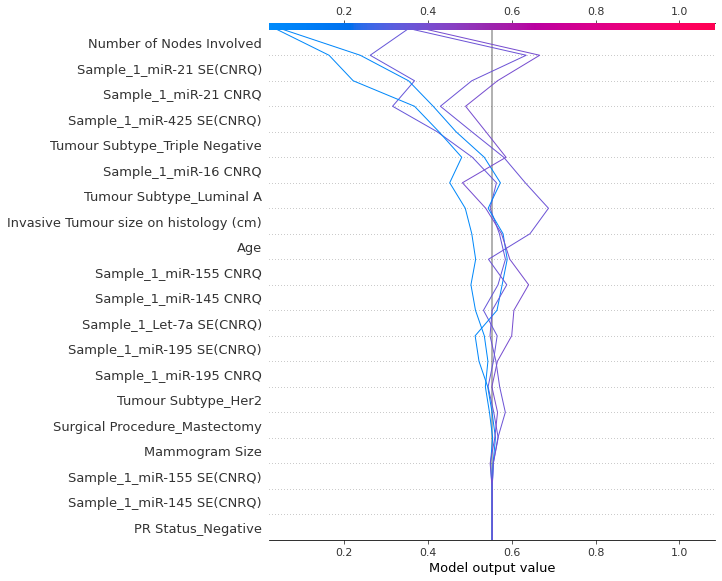

In [1658]:
# Predefined samples
sample_patients_idx = [1,6,8,9,20]

shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

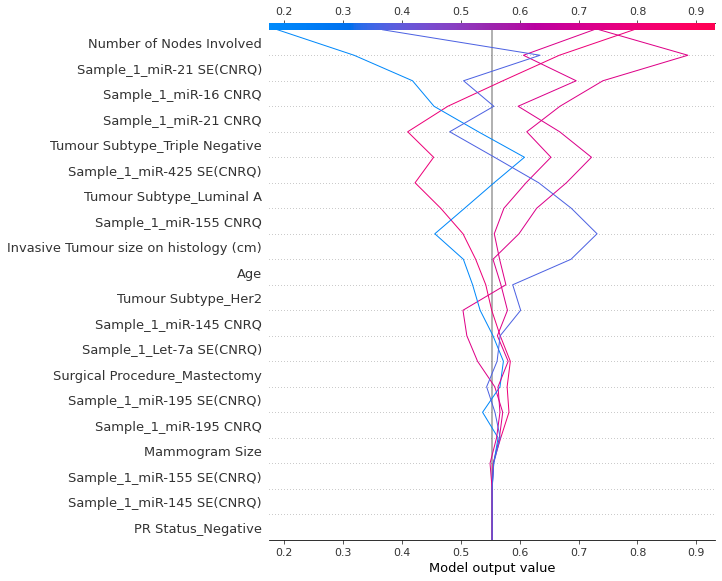

In [1543]:
# Predefined samples
sample_patients_idx = [16,17,18,19,20]

shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

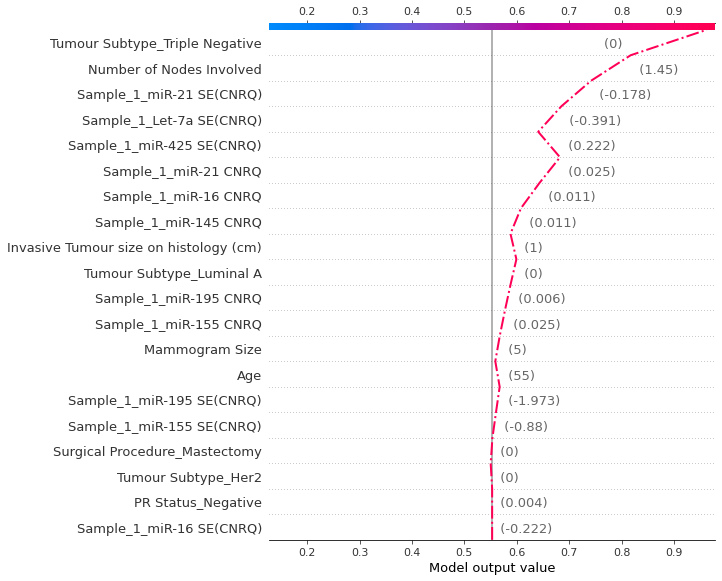

In [1662]:
shap.decision_plot(expected_value, shap_xgb_values_test[13], 
                   df_test.iloc[13], highlight=0, feature_names=features)

In [1668]:
df_test.iloc[[13]]

Age  Mammogram Size  Tumour Grade  \
108  55.0             5.0             1   

     Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
108                                    1.45                       0.0   

     Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
108             -0.391296                  0.010914              -0.229584   

     Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
108                   0.024736              -0.879925   

     Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
108                   0.011003             -0.221818   

     Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
108                  0.005667              -1.973467   

     Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
108                   0.025465              -0.17819   

     Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
108                  0.024225               0.221818   

     Sample_1_miR-425 SE(CNRQ)  PR Status_Negative  PR Status_Positive  \
108                   0.004053                   1                   0   

     PR Status_nan  HER2 Status_Negative  HER2 Status_Positive  \
108              0                     1                     0   

     HER2 Status_nan  Node Result_Negative  Node Result_Positive  \
108                0                     0                     1   

     Node Result_nan  Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
108                0                              0                       1   

     Surgical Procedure_nan  Final combined pCR status_No  \
108                       0                             1   

     Final combined pCR status_Yes  Final combined pCR status_nan  \
108                              0                              0   

     Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
108                                     0                                 0   

     Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
108                                    1                                 0   

     Tumour bed response to NACT_nan  Tumour Subtype_Her2  \
108                                0                    0   

     Tumour Subtype_Luminal A  Tumour Subtype_Luminal B  \
108                         0                         0   

     Tumour Subtype_Triple Negative  Tumour Subtype_nan  
108                               1                   0

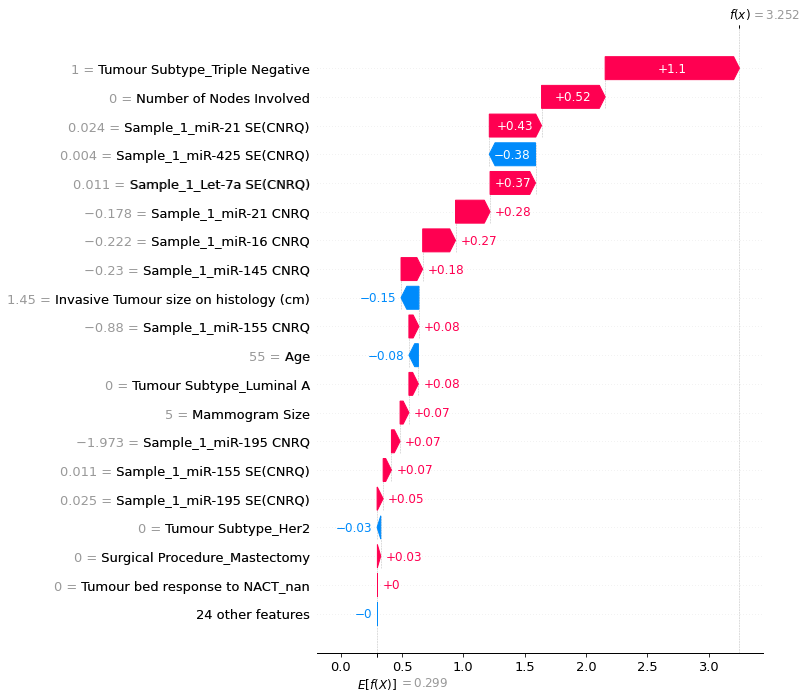

In [1663]:
shap.plots.waterfall(sh_values[13], max_display=20)

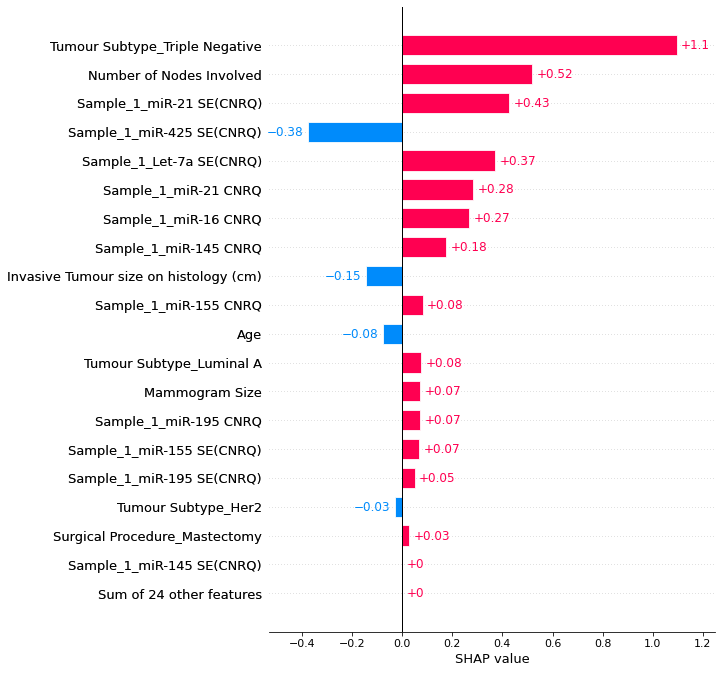

In [1664]:
# Generate SHAP Local Variable Importance Plot

shap.plots.bar(sh_values[13], max_display=20)

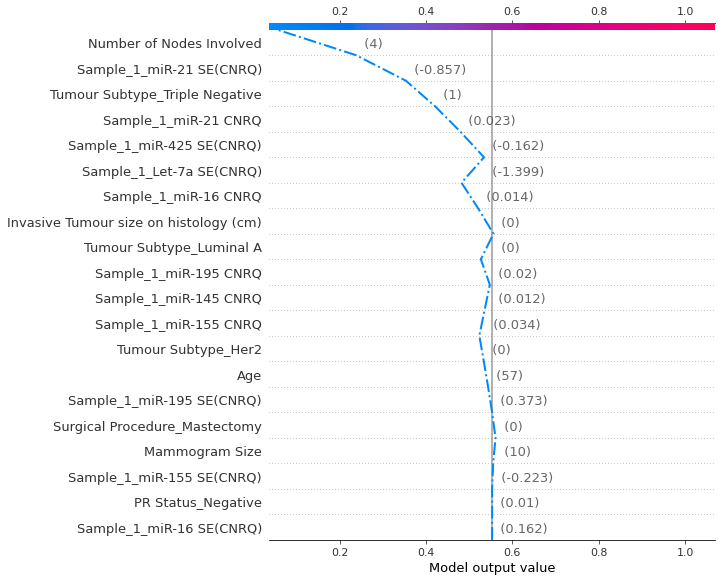

In [1547]:
shap.decision_plot(expected_value, shap_xgb_values_test[6], df_test.iloc[6], highlight=0, feature_names=features)

In [1669]:
df_test.iloc[[6]]

Age  Mammogram Size  Tumour Grade  \
15  57.0            10.0             0   

    Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
15                                     4.0                      15.0   

    Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
15              -1.39896                  0.012001              -0.243442   

    Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
15                   0.033577              -0.223146   

    Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  Sample_1_miR-16 SE(CNRQ)  \
15                   0.013657              0.162184                    0.0202   

    Sample_1_miR-195 CNRQ  Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
15                0.37329                   0.022536             -0.856901   

    Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
15                  0.036136              -0.162184   

    Sample_1_miR-425 SE(CNRQ)  PR Status_Negative  PR Status_Positive  \
15                   0.010411                   0                   1   

    PR Status_nan  HER2 Status_Negative  HER2 Status_Positive  \
15              0                     0                     1   

    HER2 Status_nan  Node Result_Negative  Node Result_Positive  \
15                0                     0                     1   

    Node Result_nan  Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
15                0                              1                       0   

    Surgical Procedure_nan  Final combined pCR status_No  \
15                       0                             1   

    Final combined pCR status_Yes  Final combined pCR status_nan  \
15                              0                              0   

    Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
15                                     0                                 0   

    Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
15                                    1                                 0   

    Tumour bed response to NACT_nan  Tumour Subtype_Her2  \
15                                0                    0   

    Tumour Subtype_Luminal A  Tumour Subtype_Luminal B  \
15                         0                         1   

    Tumour Subtype_Triple Negative  Tumour Subtype_nan  
15                               0                   0

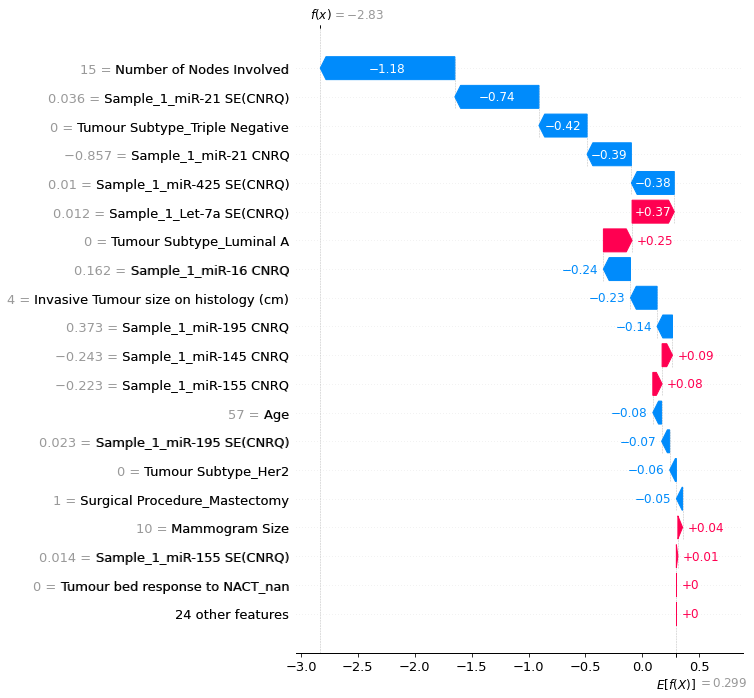

In [1548]:
shap.plots.waterfall(sh_values[6], max_display=20)

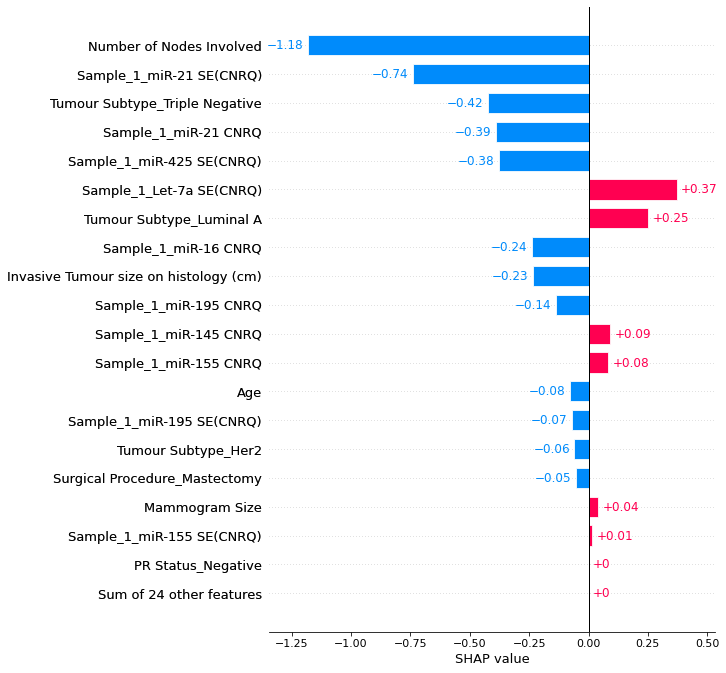

In [1549]:
shap.plots.bar(sh_values[6], max_display=20)

In [1665]:
df_ = df_test.drop('Tumour Grade', axis=1)
sample_patient_ = df_.iloc[13]
sample_patient_data = sample_patient_.values.reshape(1,-1)

xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', data=X_test)

shap_values = xgb_explain_prob.shap_values(sample_patient_data)

shap.initjs()
shap.force_plot(xgb_explain.expected_value, shap_values, sample_patient_data, feature_names=features)

In [1551]:
df_ = df_test.drop('Tumour Grade', axis=1)
sample_patient_ = df_.iloc[6]
sample_patient_data = sample_patient_.values.reshape(1,-1)

xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', data=X_test)

shap_values = xgb_explain_prob.shap_values(sample_patient_data)

shap.initjs()
shap.force_plot(xgb_explain.expected_value, shap_values, sample_patient_data, feature_names=features)

In [1552]:
df_shap = pd.DataFrame(data=shap_values, columns=features)

In [1553]:
df_shap

Age  Mammogram Size  Invasive Tumour size on histology (cm)  \
0 -0.009898        0.005586                                -0.03559   

   Number of Nodes Involved  Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  \
0                 -0.182395                   0.0                  0.052243   

   Sample_1_miR-145 CNRQ  Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
0               0.012276                        0.0                0.01208   

   Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  Sample_1_miR-16 SE(CNRQ)  \
0                   0.002294             -0.038518                       0.0   

   Sample_1_miR-195 CNRQ  Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
0              -0.020814                  -0.009218             -0.058935   

   Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  Sample_1_miR-425 SE(CNRQ)  \
0                 -0.115233                    0.0                  -0.054615   

   PR Status_Negative  PR Status_Positive  PR Status_nan  \
0                 0.0                 0.0            0.0   

   HER2 Status_Negative  HER2 Status_Positive  HER2 Status_nan  \
0                   0.0                   0.0              0.0   

   Node Result_Negative  Node Result_Positive  Node Result_nan  \
0                   0.0                   0.0              0.0   

   Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
0                      -0.008118                     0.0   

   Surgical Procedure_nan  Final combined pCR status_No  \
0                     0.0                           0.0   

   Final combined pCR status_Yes  Final combined pCR status_nan  \
0                            0.0                            0.0   

   Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
0                                   0.0                               0.0   

   Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
0                                  0.0                               0.0   

   Tumour bed response to NACT_nan  Tumour Subtype_Her2  \
0                              0.0            -0.010357   

   Tumour Subtype_Luminal A  Tumour Subtype_Luminal B  \
0                  0.029195                       0.0   

   Tumour Subtype_Triple Negative  Tumour Subtype_nan  
0                       -0.067333                 0.0

In [1554]:
df_shap_key_values = df_shap.loc[: , [(df_shap[col] != 0).any() 
                                      for col in df_shap.columns]].transpose().sort_values(by=0, 
                                                                                           ascending=True)

In [1555]:
df_shap_key_values

0
Number of Nodes Involved               -0.182395
Sample_1_miR-21 SE(CNRQ)               -0.115233
Tumour Subtype_Triple Negative         -0.067333
Sample_1_miR-21 CNRQ                   -0.058935
Sample_1_miR-425 SE(CNRQ)              -0.054615
Sample_1_miR-16 CNRQ                   -0.038518
Invasive Tumour size on histology (cm) -0.035590
Sample_1_miR-195 CNRQ                  -0.020814
Tumour Subtype_Her2                    -0.010357
Age                                    -0.009898
Sample_1_miR-195 SE(CNRQ)              -0.009218
Surgical Procedure_Mastectomy          -0.008118
Sample_1_miR-155 SE(CNRQ)               0.002294
Mammogram Size                          0.005586
Sample_1_miR-155 CNRQ                   0.012080
Sample_1_miR-145 CNRQ                   0.012276
Tumour Subtype_Luminal A                0.029195
Sample_1_Let-7a SE(CNRQ)                0.052243

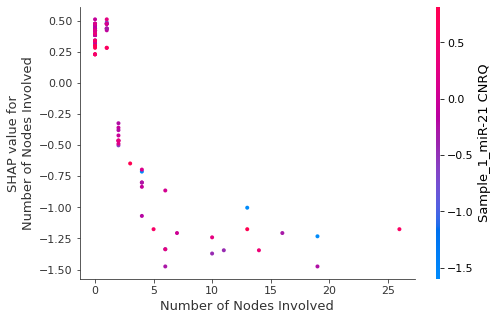

In [1556]:
shap.dependence_plot('Number of Nodes Involved', shap_values_tr, X_train, 
                     interaction_index="Sample_1_miR-21 CNRQ", feature_names=features)

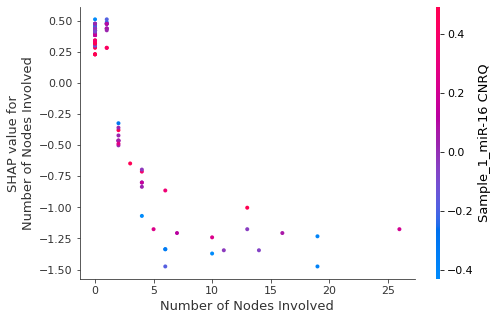

In [1557]:
shap.dependence_plot('Number of Nodes Involved', shap_values_tr, X_train, 
                     interaction_index="Sample_1_miR-16 CNRQ", feature_names=features)

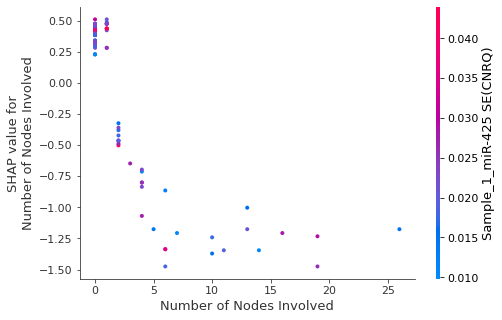

In [1558]:
shap.dependence_plot('Number of Nodes Involved', shap_values_tr, X_train, 
                     interaction_index="Sample_1_miR-425 SE(CNRQ)", feature_names=features)